## Complete Case Analysis


Complete-case analysis (CCA), also called "list-wise deletion" of cases, consists in **discarding** observations where values in **any** of the variables are missing. Complete Case Analysis means literally analysing only those observations for which there is information in **all** of the variables in the dataset. 

### Which variables can I impute with CCA?

CCA can be applied to both categorical and numerical variables.


### Assumptions

CCA works well when the data are missing completely at random (MCAR). In fact, we should use CCA if we have reasons to believe that data is missing at random, and not otherwise. When data is MCAR, excluding observations with missing information is in essence the same as randomly excluding some observations from the dataset. Therefore the dataset after CCA is a fair representation of the original dataset. 


### Advantages

- Easy to implement
- No data manipulation required
- Preserves variable distribution (if data is MCAR, then the distribution of the variables of the reduced dataset should match the distribution in the original dataset)

### Disadvantages

- It can exclude a large fraction of the original dataset (if missing data is abundant)
- Excluded observations could be informative for the analysis (if data is not missing at random)
- CCA will create a biased dataset if the complete cases differ from the original data (e.g., when missing information is in fact MAR or NMAR and not missing at random).
- When using our models in production, the model will not know how to handle missing data

### When to use CCA

- Data is missing completely at random
- No more than 5% of the total dataset contains missing data

In practice, CCA may be an acceptable method when the amount of missing information is small. Unfortunately, there is no rule of thumb to determine how much missing data is small or negligible. However, as general guidance, if the total amount of missing data is ~5% of the original dataset or less, CCA is a viable option.

In many real life datasets, the amount of missing data is never small, and therefore CCA is typically never an option.

### CCA and models in production

When using CCA, we remove all observations that contain missing information. However, the data that we want to score with our model, may indeed contain missing information. This will pose a problem when using our model in live systems, or as we call it, when putting or models into production: when an observation contains missing data, the model will not be able to handle it. 

In order to avoid this problem, when putting models into production we need to do 1 of 2 things: either we do not score observations with missing data, or we replace the missing values by another number. We can choose any from the imputation techniques that we will discuss in the following lectures to replace NA in the data to be scored.

## In this demo:

We will use the House Prices dataset to demonstrate how to perform Complete Case Analysis.

- For instructions on how to download the dataset, please refer to the lecture **Datasets** in **Section 1** of the course.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# to show all the columns of the dataframe in the notebook
pd.set_option('display.max_columns', None)

In [25]:
# let's load the House Prices dataset
# and explore its shape (rows and columns)

data = pd.read_excel('../houseprice.xls')
data.shape

(2930, 82)

In [26]:
# let's visualise the dataset
data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior1st,Exterior2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [27]:
# Replace the space in the column names
data.columns = data.columns.str.replace(' ', '')
data.columns

Index(['Order', 'PID', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemod/Add', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 

In [28]:
# find the variables with missing observations

vars_with_na = [var for var in data.columns if data[var].isnull().mean() > 0]
vars_with_na

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Electrical',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [29]:
# let's find out whether they are numerical or categorical
data[vars_with_na].dtypes

LotFrontage     float64
Alley            object
MasVnrType       object
MasVnrArea      float64
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinSF1      float64
BsmtFinType2     object
BsmtFinSF2      float64
BsmtUnfSF       float64
TotalBsmtSF     float64
Electrical       object
BsmtFullBath    float64
BsmtHalfBath    float64
FireplaceQu      object
GarageType       object
GarageYrBlt     float64
GarageFinish     object
GarageCars      float64
GarageArea      float64
GarageQual       object
GarageCond       object
PoolQC           object
Fence            object
MiscFeature      object
dtype: object

There are both numerical and categorical variables with missing observations. We can see from the variable types that some are float and some are object.

In [32]:
# let's have a look at the values of the variables with
# missing data

data[vars_with_na].head(10)

,LotFrontage,Alley,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Electrical,BsmtFullBath,BsmtHalfBath,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PoolQC,Fence,MiscFeature
0,141.0,NaN,Stone,112.0,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,SBrkr,1.0,0.0,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,NaN,NaN,NaN
1,80.0,NaN,None,0.0,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,SBrkr,0.0,0.0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,NaN,MnPrv,NaN
2,81.0,NaN,BrkFace,108.0,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,SBrkr,0.0,0.0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,NaN,NaN,Gar2
3,93.0,NaN,None,0.0,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,SBrkr,1.0,0.0,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,NaN,NaN,NaN
4,74.0,NaN,None,0.0,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,SBrkr,0.0,0.0,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,NaN,MnPrv,NaN
5,78.0,NaN,BrkFace,20.0,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,SBrkr,0.0,0.0,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,NaN,NaN,NaN
6,41.0,NaN,None,0.0,Gd,TA,Mn,GLQ,616.0,Unf,0.0,722.0,1338.0,SBrkr,1.0,0.0,NaN,Attchd,2001.0,Fin,2.0,582.0,TA,TA,NaN,NaN,NaN
7,43.0,NaN,None,0.0,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,SBrkr,0.0,0.0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,NaN,NaN,NaN
8,39.0,NaN,None,0.0,Gd,TA,No,GLQ,1180.0,Unf,0.0,415.0,1595.0,SBrkr,1.0,0.0,TA,Attchd,1995.0,RFn,2.0,608.0,TA,TA,NaN,NaN,NaN
9,60.0,NaN,None,0.0,TA,TA,No,Unf,0.0,Unf,0.0,994.0,994.0,SBrkr,0.0,0.0,TA,Attchd,1999.0,Fin,2.0,442.0,TA,TA,NaN,NaN,NaN


In [34]:
data_na = data[vars_with_na].isnull().mean()
data_na

LotFrontage     0.167235
Alley           0.932423
MasVnrType      0.007850
MasVnrArea      0.007850
BsmtQual        0.027304
BsmtCond        0.027304
BsmtExposure    0.028328
BsmtFinType1    0.027304
BsmtFinSF1      0.000341
BsmtFinType2    0.027645
BsmtFinSF2      0.000341
BsmtUnfSF       0.000341
TotalBsmtSF     0.000341
Electrical      0.000341
BsmtFullBath    0.000683
BsmtHalfBath    0.000683
FireplaceQu     0.485324
GarageType      0.053584
GarageYrBlt     0.054266
GarageFinish    0.054266
GarageCars      0.000341
GarageArea      0.000341
GarageQual      0.054266
GarageCond      0.054266
PoolQC          0.995563
Fence           0.804778
MiscFeature     0.963823
dtype: float64

In [35]:
# let's find out the percentage of observations missing per variable

# calculate the percentage of missing (as we did in section 3)
# using the isnull() and mean() methods from pandas
data_na = data[vars_with_na].isnull().mean()

# transform the array into a dataframe
data_na = pd.DataFrame(data_na.reset_index())

# add column names to the dataframe
data_na.columns = ['variable', 'na_percentage']

# order the dataframe according to percentage of na per variable
data_na.sort_values(by='na_percentage', ascending=False, inplace=True)

# show
data_na

,variable,na_percentage
24,PoolQC,0.995563
26,MiscFeature,0.963823
1,Alley,0.932423
25,Fence,0.804778
16,FireplaceQu,0.485324
0,LotFrontage,0.167235
23,GarageCond,0.054266
22,GarageQual,0.054266
19,GarageFinish,0.054266
18,GarageYrBlt,0.054266


The first 6 variables contain a lot of missing information. So we can't use CCA if we consider those variables, as most of the observations in the dataset will be discarded. We could otherwise use CCA if we omit using those variables with a lot of NA.

For this demo, I will ignore the first 6 variables with a lot of missing data, and proceed with CCA in the remaining of the dataset.

In [36]:
# capture variables with no or less than 5% NA

vars_cca = [var for var in data.columns if data[var].isnull().mean() < 0.05]
vars_cca

['Order',
 'PID',
 'MSSubClass',
 'MSZoning',
 'LotArea',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemod/Add',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SaleType'

In [37]:
# calculate percentage of observations with complete
# cases: i.e., with values for all the variables

# the method dropna(), discards the observations that contain
# na in any of the rows / columns

len(data[vars_cca].dropna()) / len(data)

0.9627986348122867

In [38]:
# create the complete case dataset
# in other words, remove observations with na in any variable

data_cca = data[vars_cca].dropna()
data.shape, data_cca.shape

((2930, 82), (2821, 71))

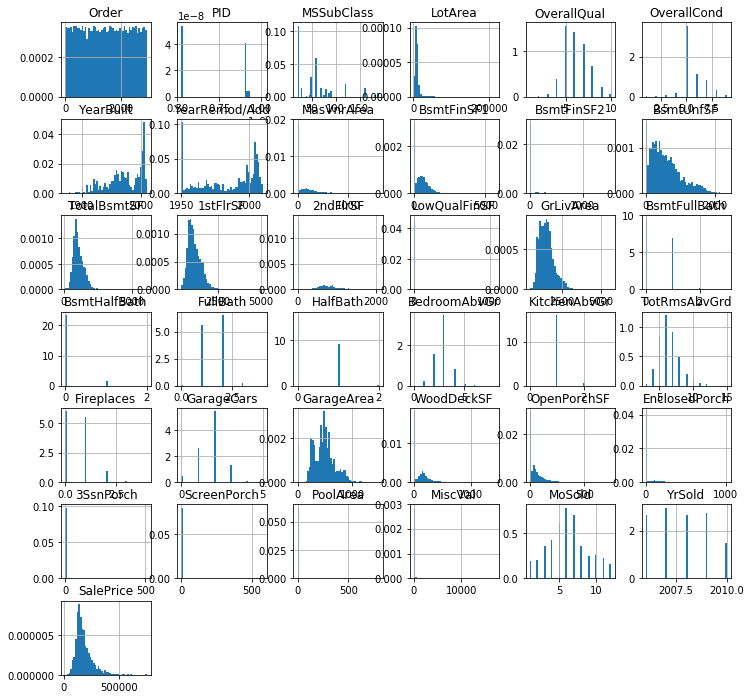

In [39]:
# plot the histograms for all numerival variables in the complete
# case dataset (as we did in section 3)

data_cca.hist(bins=50, density=True, figsize=(12, 12))
plt.show()

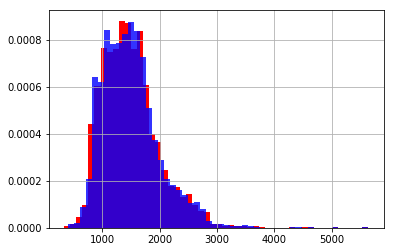

In [40]:
## let's check the distribution of a few variables before and after 
# cca: histogram

fig = plt.figure()
ax = fig.add_subplot(111)

# original data
data['GrLivArea'].hist(bins=50, ax=ax, density=True, color='red')

# data after cca, the argument alpha makes the color transparent, so we can
# see the overlay of the 2 distributions
data_cca['GrLivArea'].hist(bins=50, ax=ax, color='blue', density=True, alpha=0.8)

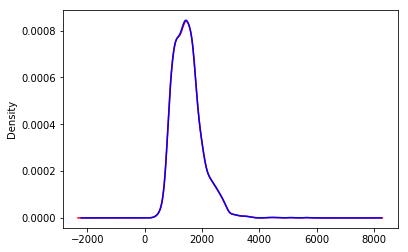

In [41]:
## let's check the distribution of a few variables before and after 
# cca: density plot

fig = plt.figure()
ax = fig.add_subplot(111)

# original data
data['GrLivArea'].plot.density(color='red')

# data after cca
data_cca['GrLivArea'].plot.density(color='blue')

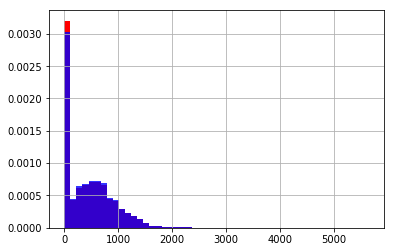

In [42]:
## let's check the distribution of a few variables before and after 
# cca: histogram

fig = plt.figure()
ax = fig.add_subplot(111)

# original data
data['BsmtFinSF1'].hist(bins=50, ax=ax, density=True, color='red')

# data after cca, the argument alpha makes the color transparent, so we can
# see the overlay of the 2 distributions
data_cca['BsmtFinSF1'].hist(bins=50, ax=ax, color='blue', density=True, alpha=0.8)

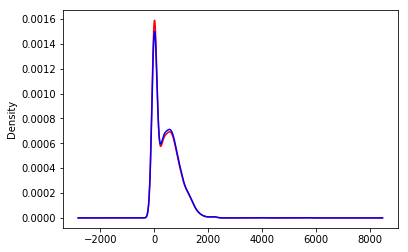

In [43]:
## let's check the distribution of a few variables before and after 
# cca: density plot

fig = plt.figure()
ax = fig.add_subplot(111)

# original data
data['BsmtFinSF1'].plot.density(color='red')

# data after cca
data_cca['BsmtFinSF1'].plot.density(color='blue')

As we can see from the above plots, the distribution of the selected numerical variables in the original and complete case dataset is very similar, which is what we expect from CCA if data is missing at random and only for a small proportion of the observations.

In the next cells I will explore the distribution of categorical variables. To do so, I will evaluate the percentage of observations that show each of the unique categories, as we did in sections 2 and 3 of the course.

In [44]:
# the following function captures the percentage of observations
# for each category in the original and complete case dataset
# and puts them together in a new dataframe


def categorical_distribution(df, df_cca, variable):
    tmp = pd.concat(
        [
            # percentage of observations per category, original data
            df[variable].value_counts() / len(df),

            # percentage of observations per category, cca data
            df_cca[variable].value_counts() / len(df_cca)
        ],
        axis=1)

    # add column names
    tmp.columns = ['original', 'cca']

    return tmp

In [45]:
# run the function in a categorical variable
categorical_distribution(data, data_cca, 'BsmtQual')

,original,cca
TA,0.437884,0.454449
Gd,0.416041,0.424672
Ex,0.088055,0.088976
Fa,0.030034,0.031195
Po,0.000683,0.000709


In [46]:
categorical_distribution(data, data_cca, 'MasVnrType')

,original,cca
None,0.597952,0.595179
BrkFace,0.300341,0.308401
Stone,0.084983,0.088267
BrkCmn,0.008532,0.007799
CBlock,0.000341,0.000354


In [47]:
categorical_distribution(data, data_cca, 'SaleCondition')

,original,cca
Normal,0.823549,0.826303
Partial,0.083618,0.082595
Abnorml,0.064846,0.065580
Family,0.015700,0.016306
Alloca,0.008191,0.005672
AdjLand,0.004096,0.003545


As we can see from the output of the cells above, the distribution of houses in each of the categories, is very similar in the original and complete case dataset, which again, is what is expected if the data is missing completely at random, and the percentage of missing data is small.